In [2]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud
from collections import Counter
import datetime 
import torch
from nltk.corpus import stopwords

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

/Users/alessandropranzo/.pyenv/versions/3.10.15/envs/nlp_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: mps


## EDA

In [3]:
trial_df = pd.read_csv("cleaned_data/train_data/ArgentinaGermanyFinal77.csv")

In [94]:
trial_df.columns

Index(['ID', 'MatchID', 'PeriodID', 'EventType', 'Timestamp', 'Tweet',
       'tweet_length', 'tweet_n_words'],
      dtype='object')

In [4]:
trial_df.head()

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,10_0,10,0,0,1405277400000,injury update: khedira (calf) is replaced by k...
1,10_0,10,0,0,1405277400000,where does brazil's 2014 world cup campaign ra...
2,10_0,10,0,0,1405277400000,arg for the world cup!!!
3,10_0,10,0,0,1405277400000,rt for ger fav for arg i'll follow all the peo...
4,10_0,10,0,0,1405277400000,every mexican is rooting for argentina so i gu...


In [5]:
trial_df.shape

(498315, 6)

In [6]:
trial_df[trial_df["EventType"]==1].shape

(183828, 6)

In [7]:
trial_df["tweet_length"] = trial_df["Tweet"].apply(len)
trial_df["tweet_n_words"] = trial_df["Tweet"].apply(lambda x: len(x.split()))

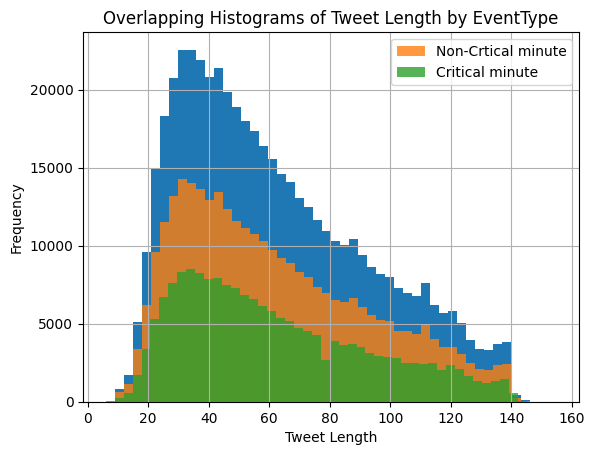

In [8]:
trial_df["tweet_length"].hist(bins=50)
trial_df[trial_df["EventType"] == 0]["tweet_length"].hist(bins=50, alpha=0.8, label='Non-Crtical minute')
trial_df[trial_df["EventType"] == 1]["tweet_length"].hist(bins=50, alpha=0.8, label='Critical minute')
plt.legend()
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms of Tweet Length by EventType')
plt.show()

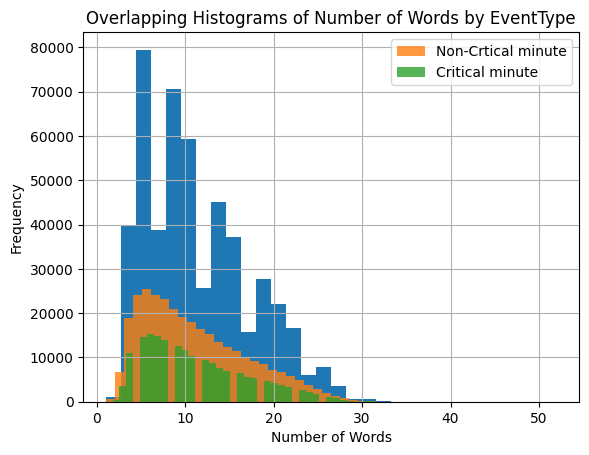

In [39]:
trial_df["tweet_n_words"].hist(bins=30)
trial_df[trial_df["EventType"] == 0]["tweet_n_words"].hist(bins=50, alpha=0.8, label='Non-Crtical minute')
trial_df[trial_df["EventType"] == 1]["tweet_n_words"].hist(bins=50, alpha=0.8, label='Critical minute')
plt.legend()
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.title('Overlapping Histograms of Number of Words by EventType')
plt.show()

In [67]:
def most_common_words(texts, n_words=10):
    all_words = ' '.join(texts)
    stop_words = set(stopwords.words('english'))
    words = [w for w in all_words.split() if len(w) > 1 and w not in stop_words]
    return Counter(words).most_common(n_words)

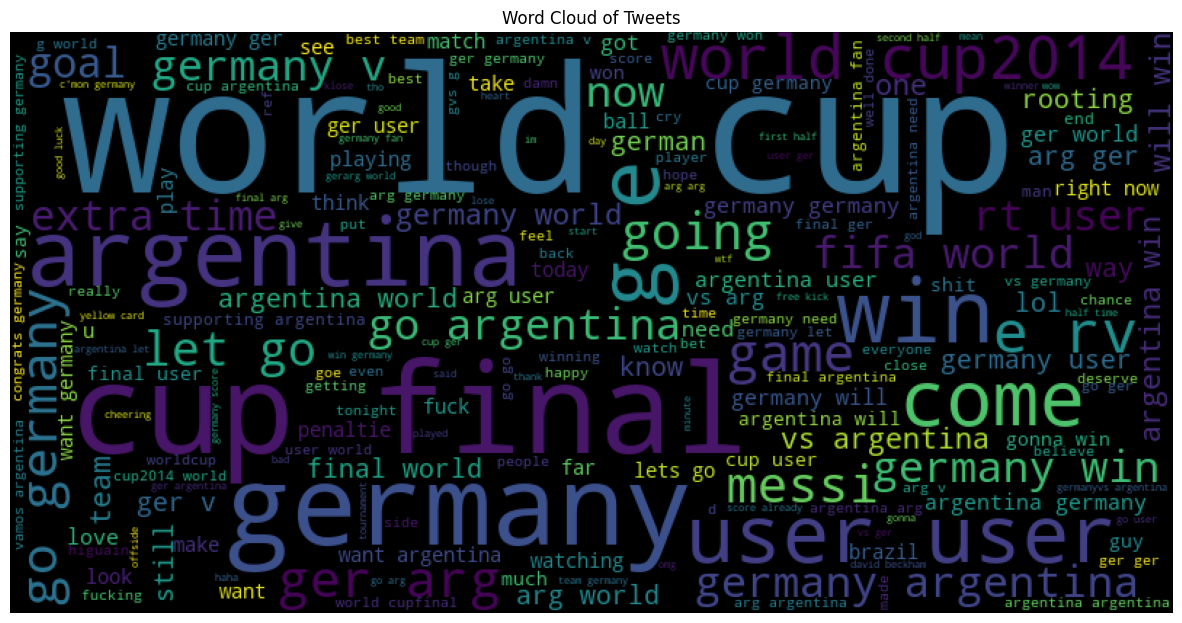

In [68]:
all_words = ' '.join(trial_df["Tweet"])
wordcloud = WordCloud(width=800, height=400).generate(all_words)
del all_words

plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis('off')
plt.title('Word Cloud of Tweets')
plt.show()

In [69]:
total_dataset_most_common_words = most_common_words(trial_df["Tweet"], 50)

In [70]:
total_dataset_most_common_words

[('germany', 185169),
 ('argentina', 156000),
 ('world', 133013),
 ('cup', 103467),
 ('ger', 77335),
 ('user', 73773),
 ('arg', 70024),
 ('final', 49388),
 ('win', 44383),
 ('go', 37969),
 ('messi', 24602),
 ('come', 23213),
 ('like', 20331),
 ("i'm", 18481),
 ('game', 17375),
 ('team', 15918),
 ('want', 15797),
 ('cup2014', 15664),
 ('“user:', 14769),
 ('vs', 14520),
 ('rvs', 14520),
 ('goal', 14379),
 ('"user:', 14034),
 ('going', 13978),
 ('score', 13952),
 ("let's", 13787),
 ('worldcup', 13175),
 ('time', 13069),
 ('get', 12580),
 ('good', 12382),
 ('one', 12053),
 ('fifa', 11986),
 ('got', 10101),
 ('gonna', 9527),
 ('rt', 9246),
 ('germany!', 9137),
 ('still', 9115),
 ('playing', 9027),
 ('germany.', 8627),
 ('really', 8463),
 ("germany's", 8454),
 ('watching', 8424),
 ('well', 8385),
 ('gerarg', 8344),
 ('better', 8253),
 ('best', 8152),
 ('would', 8142),
 ('think', 8055),
 ('brazil', 8026),
 ('see', 7948)]

In [71]:
def most_unique_common_words(texts, words_to_exclude,n_words=5):
    all_words = ' '.join(texts)
    stop_words = set(stopwords.words('english'))
    for element in words_to_exclude:
        stop_words.add(element[0])
    words = [w for w in all_words.split() if len(w) > 1 and w not in stop_words]
    return Counter(words).most_common()[:5]

In [72]:
most_unique_common_words(trial_df[trial_df["EventType"] == 0]["Tweet"], total_dataset_most_common_words)

[('rooting', 4929),
 ('wins', 4896),
 ('supporting', 4773),
 ('lol', 4685),
 ("argentina's", 4666)]

In [73]:
most_unique_common_words(trial_df[trial_df["EventType"] == 1]["Tweet"], total_dataset_most_common_words)

[('congrats', 4093),
 ('extra', 3903),
 ('half', 3657),
 ('fuck', 3606),
 ('2014', 3593)]

In [74]:
grouped_df = trial_df.groupby('ID').agg({'Timestamp': list,'Tweet': list,'EventType': list, "tweet_length": np.mean, "tweet_n_words": np.mean}).reset_index()

/var/folders/14/_5lf5fw13cldzrf7ntwtb8080000gn/T/ipykernel_62001/174574708.py:1: FutureWarning: The provided callable <function mean at 0x106e2bb50> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_df = trial_df.groupby('ID').agg({'Timestamp': list,'Tweet': list,'EventType': list, "tweet_length": np.mean, "tweet_n_words": np.mean}).reset_index()


In [75]:
grouped_df["n_tweets"] = grouped_df["Tweet"].apply(lambda x: len(x))
grouped_df["tweet_length"] = grouped_df["tweet_length"].apply(lambda x: round(x, 2))
grouped_df["tweet_n_words"] = grouped_df["tweet_n_words"].apply(lambda x: round(x, 2))

In [76]:
grouped_df.shape

(180, 7)

In [77]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,tweet_length,tweet_n_words,n_tweets
0,10_0,"[1405277400000, 1405277400000, 1405277400000, ...",[injury update: khedira (calf) is replaced by ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",65.66,12.23,2517
1,10_1,"[1405277461000, 1405277461000, 1405277461000, ...",[tbh i don't care who wins i hate germany for ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",60.66,11.25,2515
2,10_10,"[1405278001000, 1405278001000, 1405278001000, ...",[let's fucking go boy 😍😍 fire me up 😍🇩🇪🇩🇪🇩🇪🇩🇪 ...,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",54.75,10.25,2941
3,10_100,"[1405283401000, 1405283401000, 1405283401000, ...","[missed again by ger.. gervsarg, so close germ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",63.71,11.76,2695
4,10_101,"[1405283461000, 1405283461000, 1405283461000, ...","[germany have to put they're best player in, p...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",63.63,11.71,2709


In [78]:
grouped_df = grouped_df.sort_values("ID", key=(lambda x: x.apply(lambda y: int(y.split('_')[1]))))
grouped_df.reset_index(drop=True, inplace=True)

In [79]:
grouped_df.head()

,ID,Timestamp,Tweet,EventType,tweet_length,tweet_n_words,n_tweets
0,10_0,"[1405277400000, 1405277400000, 1405277400000, ...",[injury update: khedira (calf) is replaced by ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",65.66,12.23,2517
1,10_1,"[1405277461000, 1405277461000, 1405277461000, ...",[tbh i don't care who wins i hate germany for ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",60.66,11.25,2515
2,10_2,"[1405277521000, 1405277521000, 1405277521000, ...","[argentina better win fuck, ger vs arg world c...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",59.26,10.95,2629
3,10_3,"[1405277581000, 1405277581000, 1405277581000, ...",[i want argentina to win cause of messi but i ...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",59.23,11.01,2731
4,10_4,"[1405277641000, 1405277641000, 1405277641000, ...","[game time! pizza, beer and chilled sunday! ar...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",58.96,11.10,2662


In [80]:
grouped_df["n_tweets"].mean()

np.float64(2768.4166666666665)

In [81]:
grouped_df["Assertion"] = grouped_df["EventType"].apply(lambda x: False if (1 in x) and (0 in x) else True)
grouped_df["Timestamp Assertion"] = grouped_df["Timestamp"].apply(lambda x: False if (len(set(x)) == 1) else True)
print(grouped_df["Assertion"].unique())
print(grouped_df["Timestamp Assertion"].unique())

[ True]
[ True]


In [82]:
grouped_df["EventType"] = grouped_df["EventType"].apply(lambda x: x[0])
grouped_df.drop(columns=["Assertion"], inplace=True)
grouped_df.drop(columns=["Timestamp Assertion"], inplace=True)
grouped_df.head()


,ID,Timestamp,Tweet,EventType,tweet_length,tweet_n_words,n_tweets
0,10_0,"[1405277400000, 1405277400000, 1405277400000, ...",[injury update: khedira (calf) is replaced by ...,0,65.66,12.23,2517
1,10_1,"[1405277461000, 1405277461000, 1405277461000, ...",[tbh i don't care who wins i hate germany for ...,0,60.66,11.25,2515
2,10_2,"[1405277521000, 1405277521000, 1405277521000, ...","[argentina better win fuck, ger vs arg world c...",0,59.26,10.95,2629
3,10_3,"[1405277581000, 1405277581000, 1405277581000, ...",[i want argentina to win cause of messi but i ...,0,59.23,11.01,2731
4,10_4,"[1405277641000, 1405277641000, 1405277641000, ...","[game time! pizza, beer and chilled sunday! ar...",0,58.96,11.10,2662


In [83]:
grouped_df["Timestamp"] = grouped_df["Timestamp"].apply(lambda x: [datetime.datetime.fromtimestamp(y/1000) for y in x])
grouped_df["Unique Common Words"] = grouped_df["Tweet"].apply(lambda x: most_unique_common_words(x, total_dataset_most_common_words))
grouped_df.head()

,ID,Timestamp,Tweet,EventType,tweet_length,tweet_n_words,n_tweets,Unique Common Words
0,10_0,"[2014-07-13 20:50:00, 2014-07-13 20:50:00, 201...",[injury update: khedira (calf) is replaced by ...,0,65.66,12.23,2517,"[(hope, 69), (wins, 69), (supporting, 63), (fa..."
1,10_1,"[2014-07-13 20:51:01, 2014-07-13 20:51:01, 201...",[tbh i don't care who wins i hate germany for ...,0,60.66,11.25,2515,"[(kit, 66), (khedira, 63), (today, 60), (hope,..."
2,10_2,"[2014-07-13 20:52:01, 2014-07-13 20:52:01, 201...","[argentina better win fuck, ger vs arg world c...",0,59.26,10.95,2629,"[(hope, 75), (kit, 63), (khedira, 62), (argent..."
3,10_3,"[2014-07-13 20:53:01, 2014-07-13 20:53:01, 201...",[i want argentina to win cause of messi but i ...,0,59.23,11.01,2731,"[(hope, 85), (lets, 77), (love, 68), (argentin..."
4,10_4,"[2014-07-13 20:54:01, 2014-07-13 20:54:01, 201...","[game time! pizza, beer and chilled sunday! ar...",0,58.96,11.10,2662,"[(lets, 99), (argentina!, 70), (hope, 60), (ar..."


In [84]:
grouped_df[grouped_df["EventType"]==1].shape

(64, 8)

In [89]:
grouped_df[grouped_df["EventType"]==1][20:30]

,ID,Timestamp,Tweet,EventType,tweet_length,tweet_n_words,n_tweets,Unique Common Words
77,10_77,"[2014-07-13 22:07:01, 2014-07-13 22:07:01, 201...",[germany are starting this half off rather fla...,1,60.61,11.10,2978,"[(half, 106), (chances, 106), (close, 87), (se..."
86,10_86,"[2014-07-13 22:16:01, 2014-07-13 22:16:01, 201...",[there’s a guy named garay on argentina.. oooo...,1,57.85,10.73,3265,"[(free, 367), (kick, 264), (foul, 187), (fuck,..."
87,10_87,"[2014-07-13 22:17:01, 2014-07-13 22:17:01, 201...","[even if i want germany to win, argentina dese...",1,61.47,11.39,3382,"[(free, 349), (kick, 281), (goalie, 207), (neu..."
88,10_88,"[2014-07-13 22:18:01, 2014-07-13 22:18:01, 201...",[annoying thing is if argentina do win tonight...,1,65.63,12.03,2868,"[(goalie, 158), (free, 144), (neuer, 138), (ki..."
94,10_94,"[2014-07-13 22:24:01, 2014-07-13 22:24:01, 201...",[who do you go for? argentina of germany ? 👀👀👀...,1,62.11,11.32,2714,"[(yellow, 273), (card, 120), (cards, 109), (go..."
95,10_95,"[2014-07-13 22:25:01, 2014-07-13 22:25:01, 201...","[""user: c'mon la germany ."", go germany go! wo...",1,65.13,11.93,2618,"[(yellow, 268), (cards, 125), (card, 94), (ref..."
106,10_106,"[2014-07-13 22:36:01, 2014-07-13 22:36:01, 201...",[please have a score messi a r gvs g e r world...,1,65.32,12.02,2419,"[(palacio, 96), (higuain, 71), (coach, 64), (n..."
117,10_117,"[2014-07-13 22:47:01, 2014-07-13 22:47:01, 201...",[it still hurts me to see reus not playing. wh...,1,60.82,11.21,2673,"[(klose, 324), (last, 108), (gotze, 88), (miro..."
118,10_118,"[2014-07-13 22:48:01, 2014-07-13 22:48:01, 201...","[klose off, what a player he's been for german...",1,65.22,11.97,2648,"[(klose, 408), (last, 161), (miroslav, 128), (..."
119,10_119,"[2014-07-13 22:49:01, 2014-07-13 22:49:01, 201...","[time to go watch the game, come on germany!! ...",1,65.57,12.04,2506,"[(klose, 236), (last, 115), (miroslav, 89), (e..."


/var/folders/14/_5lf5fw13cldzrf7ntwtb8080000gn/T/ipykernel_62001/3891385940.py:25: UserWarning: Glyph 127465 (\N{REGIONAL INDICATOR SYMBOL LETTER D}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/14/_5lf5fw13cldzrf7ntwtb8080000gn/T/ipykernel_62001/3891385940.py:25: UserWarning: Glyph 127466 (\N{REGIONAL INDICATOR SYMBOL LETTER E}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


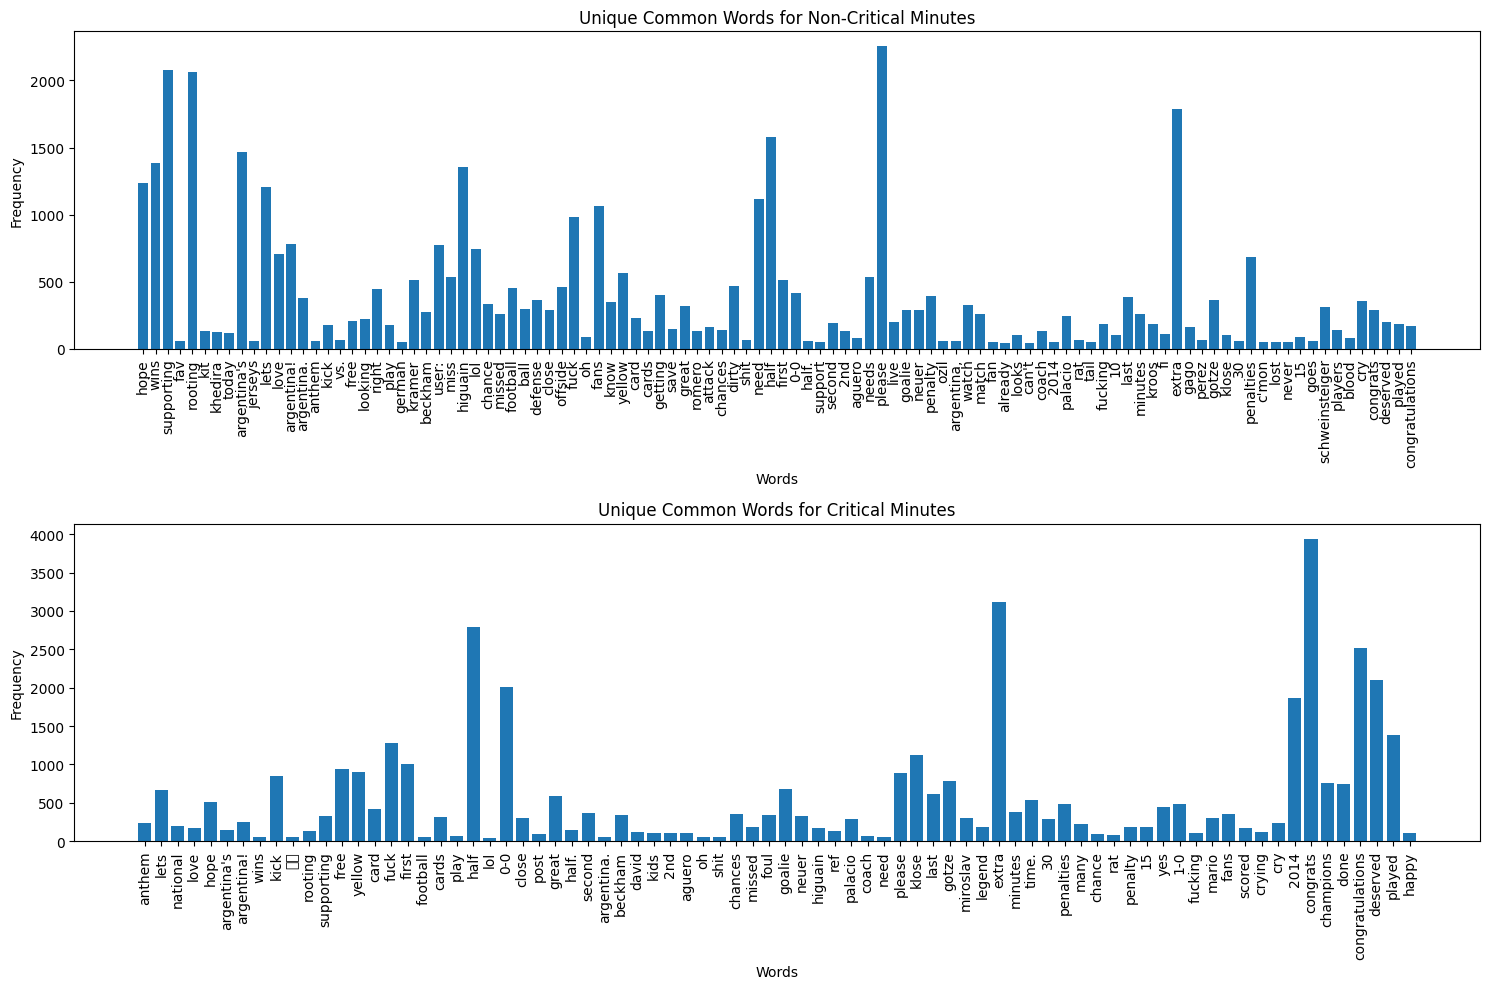

In [93]:
unique_words_eventtype_0 = Counter()
unique_words_eventtype_1 = Counter()

for words in grouped_df[grouped_df["EventType"] == 0]["Unique Common Words"]:
    unique_words_eventtype_0.update(dict(words))

for words in grouped_df[grouped_df["EventType"] == 1]["Unique Common Words"]:
    unique_words_eventtype_1.update(dict(words))

fig, axes = plt.subplots(2, 1, figsize=(15, 10))

axes[0].bar(unique_words_eventtype_0.keys(), unique_words_eventtype_0.values())
axes[0].set_title('Unique Common Words for Non-Critical Minutes')
axes[0].set_xlabel('Words')
axes[0].set_ylabel('Frequency')
axes[0].tick_params(axis='x', rotation=90)

# EventType 1
axes[1].bar(unique_words_eventtype_1.keys(), unique_words_eventtype_1.values())
axes[1].set_title('Unique Common Words for Critical Minutes')
axes[1].set_xlabel('Words')
axes[1].set_ylabel('Frequency')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In [51]:
n_tweets = grouped_df["n_tweets"].values
y = grouped_df["EventType"].values

In [52]:
print(f"The mean of the number of tweets when there is no critical event happening is {np.mean(n_tweets[y==0])} ± {np.std(n_tweets[y==0])}; and when there is a critical event happening is {np.mean(n_tweets[y==1])} ± {np.std(n_tweets[y==1])}")

The mean of the number of tweets when there is no critical event happening is 2711.094827586207 ± 329.0854091645059; and when there is a critical event happening is 2872.3125 ± 496.32555706285166


In [53]:
match_activity = Counter([])

for minute_timesteps in grouped_df["Timestamp"]:
    match_activity += Counter(minute_timesteps)

In [54]:
len(match_activity)

10801

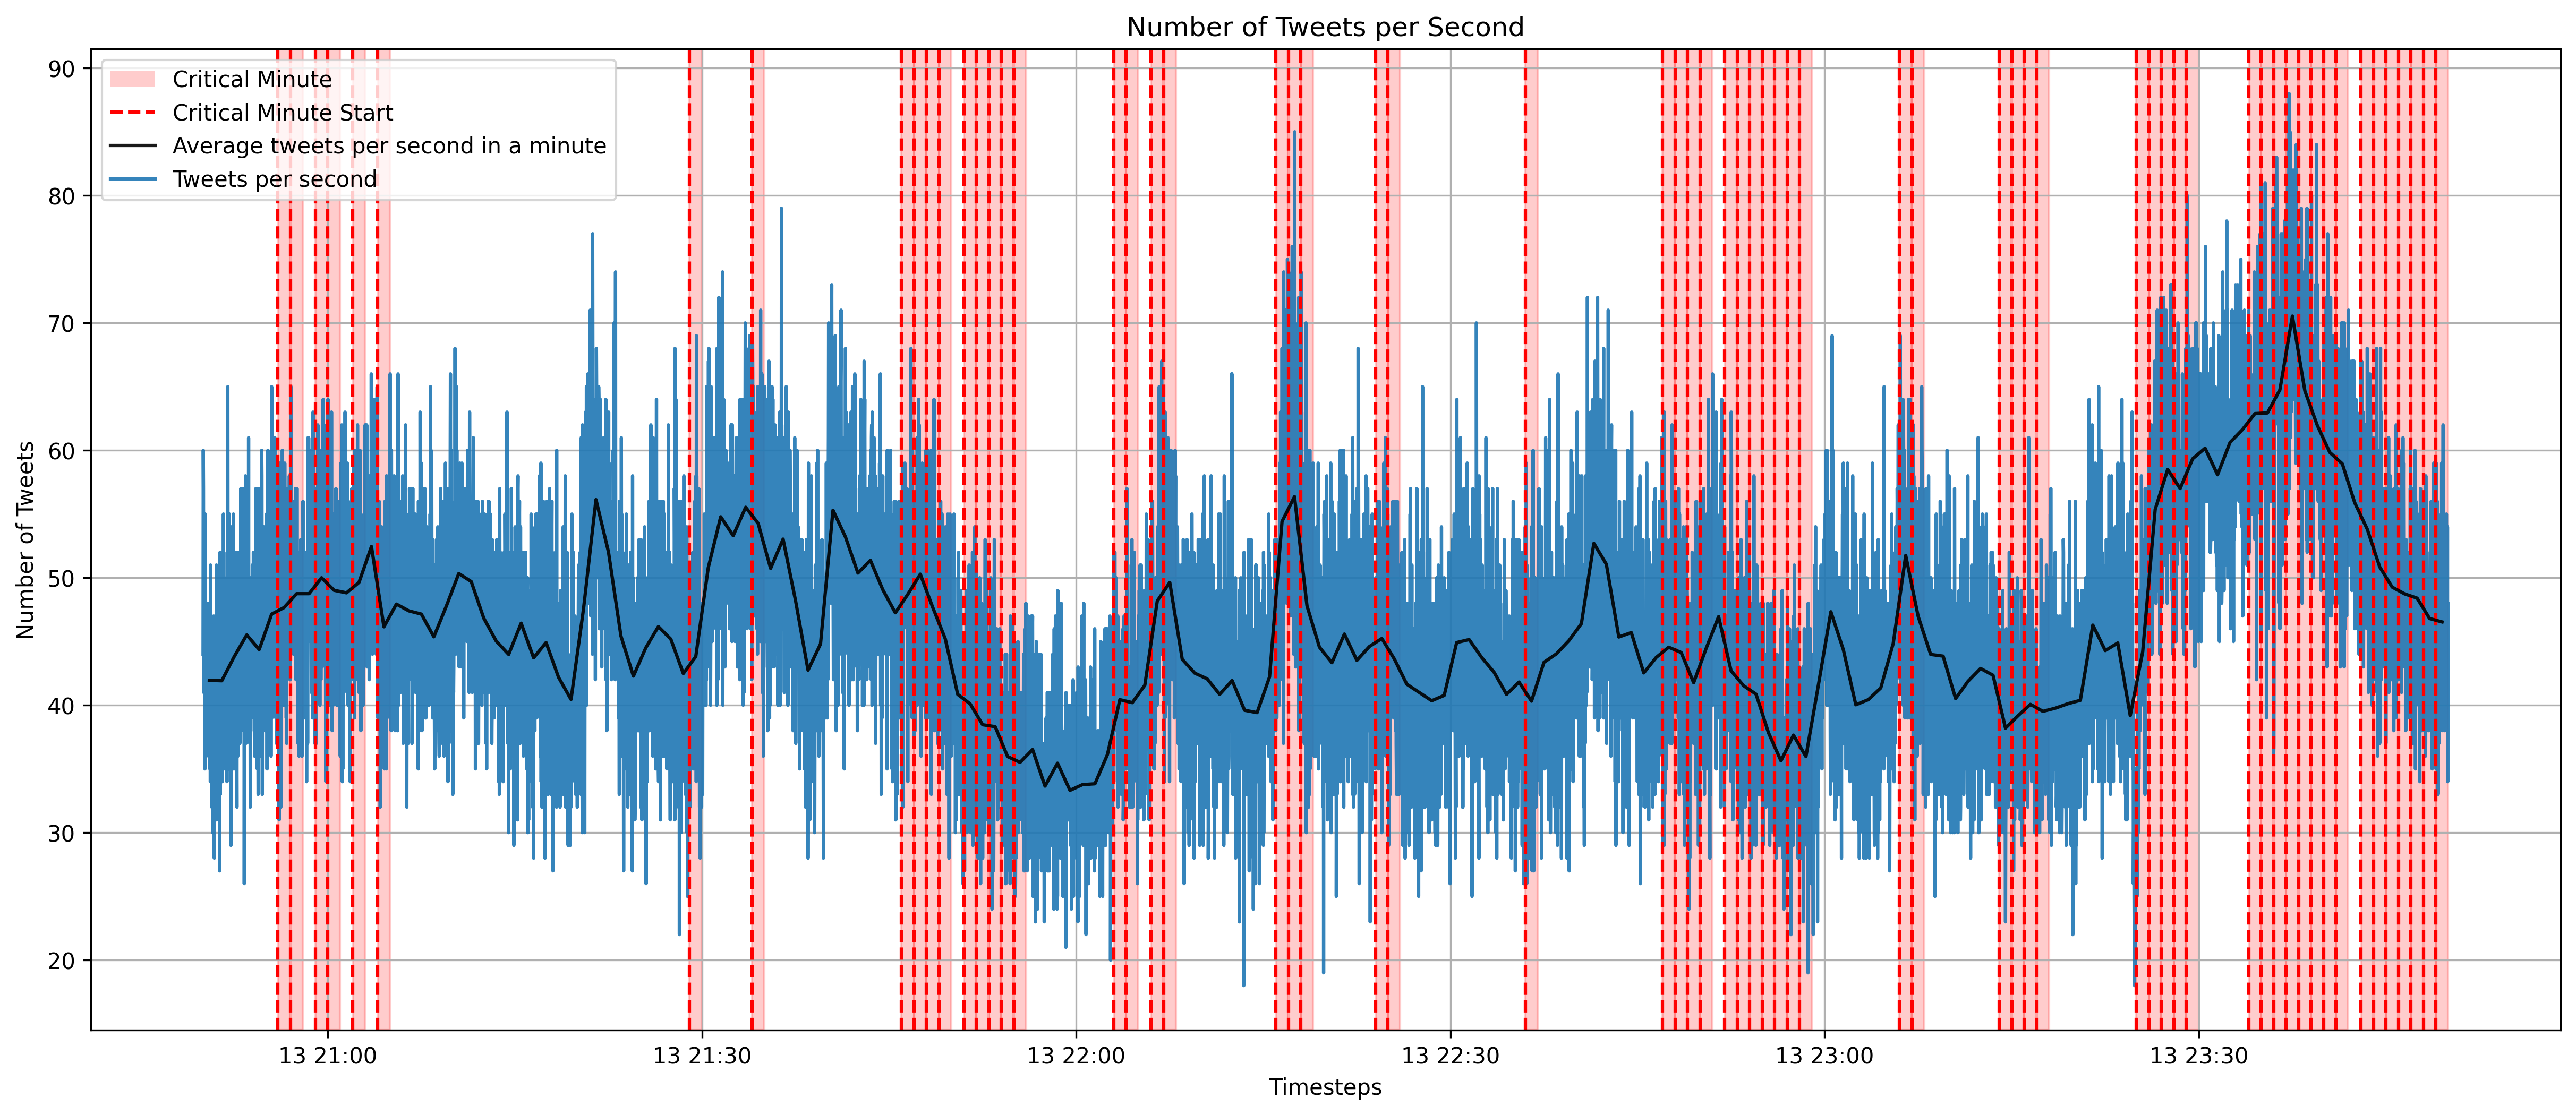

In [55]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

plt.figure(figsize=(20, 8), dpi=300)
plt.plot(list(match_activity.keys()), list(match_activity.values()), alpha=0.9)

central_minute_seconds = []
for minute, outcome in enumerate(y):
    central_minute_seconds.append(list(match_activity.keys())[minute*60 + 30])
    if outcome == 1:
        start_second = list(match_activity.keys())[minute*60]
        end_second = list(match_activity.keys())[min((minute+1)*60-1, len(match_activity)-1)]
        plt.axvline(x=start_second, color="red", linestyle="--")
        plt.axvspan(start_second, end_second, color="red", alpha=0.2)

plt.plot(central_minute_seconds, (grouped_df["n_tweets"].values) / 60, color="black", linestyle="-", alpha=0.9)
plt.xlabel('Timesteps')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets per Second')
legend_elements = [
    Patch(facecolor='red', alpha=0.2, label='Critical Minute'),
    Line2D([0], [0], color='red', linestyle='--', label='Critical Minute Start'),
    Line2D([0], [0], color='black', alpha=0.9, linestyle='-', label='Average tweets per second in a minute'),
    Line2D([0], [0], alpha=0.9, linestyle='-', label='Tweets per second')
]
plt.legend(handles=legend_elements, loc='upper left')

plt.grid(True)
plt.show()

### Interactive graph

In [56]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import BoxAnnotation

# Enable notebook output
output_notebook()

# Create figure
p = figure(width=900, height=400, x_axis_label='Timesteps', y_axis_label='Number of Tweets',
          title='Number of Tweets per Second', tools='pan,box_zoom,reset,save,wheel_zoom')

# Add main activity line
p.line(list(match_activity.keys()), list(match_activity.values()), 
       line_color='blue', alpha=0.9, legend_label='Tweets per second')

# Add average line
p.line(central_minute_seconds, (grouped_df["n_tweets"].values) / 60, 
       line_color='black', line_width=2, legend_label='Average tweets per minute')

# Add critical minutes highlighting
for minute, outcome in enumerate(y):
    if outcome == 1:
        start_second = list(match_activity.keys())[minute*60]
        end_second = list(match_activity.keys())[min((minute+1)*60-1, len(match_activity)-1)]
        p.add_layout(BoxAnnotation(left=start_second, right=end_second,
                                 fill_color='red', fill_alpha=0.2))

# Configure legend
p.legend.click_policy="hide"
p.legend.location = "top_right"
p.grid.grid_line_alpha = 0.3

# Show the plot
show(p)

Loading BokehJS ...

REMARK: we might take a weighted average of the number of tweets per second over the minute we are considering (there might be an higher number of tweets per second in the seconds when something important happens).

## Performing some initial analysis on the Embeddings of the tweets

In [ ]:
from utils.simple_embedding import embed_text

Using device: mps


In [10]:
embed_text(["Hello, my name is John."]).shape

torch.Size([1, 768])

In [8]:
BASE_MODEL_NAME = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
base_model = AutoModel.from_pretrained(BASE_MODEL_NAME).to(device)

In [ ]:
def get_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = base_model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).squeeze()

def minute_embedding(texts):
    embeddings = [get_embedding(text) for text in texts]
    return torch.stack(embeddings).mean(dim=0).cpu().numpy()

In [ ]:
from tqdm import tqdm

tqdm.pandas()
grouped_df["Embedding"] = grouped_df["Tweet"].progress_apply(lambda x: minute_embedding(x))

In [ ]:
grouped_df.head()

In [ ]:
repr_2d_pca = PCA(n_components=2).fit_transform(np.stack(grouped_df["Embedding"].values))
repr_3d_pca = PCA(n_components=3).fit_transform(np.stack(grouped_df["Embedding"].values))

In [ ]:
plt.scatter(repr_2d_pca[:, 0], repr_2d_pca[:, 1], c=y, cmap="viridis")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(repr_3d_pca[:, 0], repr_3d_pca[:, 1], repr_3d_pca[:, 2], c=y, cmap="viridis")

In [ ]:
from sklearn.manifold import TSNE

repr_2d_tsne = TSNE(n_components=2).fit_transform(np.stack(grouped_df["Embedding"].values))
repr_3d_tsne = TSNE(n_components=3).fit_transform(np.stack(grouped_df["Embedding"].values))

In [ ]:
plt.scatter(repr_2d_tsne[:, 0], repr_2d_tsne[:, 1], c=y, cmap="viridis")

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(repr_3d_tsne[:, 0], repr_3d_tsne[:, 1], repr_3d_tsne[:, 2], c=y, cmap="viridis")